# Utils

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 

import sklearn

import timeit

from matplotlib import pyplot as plt
import seaborn as sns

from eval import evaluate
from data import load_data
from dimred import fit_PCA, fit_UMAP, fit_HUMAP, fit_PMAP

In [2]:
def evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                    method_name, dimension, distance, dimensionality_reduction, num_repeats):
    
    name = method_name + "_" + str(dimension)
    print(name)

    metric_dict_over_repeats = None
    for _ in range(num_repeats):

        t_start = timeit.default_timer()
        embeddings = dimensionality_reduction(embeds, dimension)
        t_end = timeit.default_timer() 

        metric_dict = evaluate(embeddings, distance, df_meta, 
                        knn_n_splits = knn_n_splits, knn_n_neighbors = knn_n_neighbors, knn_targets = knn_targets,
                        global_n_repeats = global_n_repeats, global_distance_matrix = global_distance_matrix)
        metric_dict["Execution time"] = {"sec": [(t_end-t_start)/60]}

        if metric_dict_over_repeats is None:
            metric_dict_over_repeats = metric_dict
        else:
            for k, v in metric_dict.items():
                for kk, vv in v.items():
                    metric_dict_over_repeats[k][kk] += vv

    metric_dict_aggregated = {}
    for k, v in metric_dict_over_repeats.items():
        metric_dict_aggregated[k] = {}
        for kk, vv in v.items():
            metric_dict_aggregated[k][kk] = {}
            metric_dict_aggregated[k][kk][name+"_mean"] = round(np.mean(vv),4)
            metric_dict_aggregated[k][kk][name+"_std"] = round(np.std(vv),4)

    return pd.DataFrame.from_dict({(i,j): metric_dict_aggregated[i][j] for i in metric_dict_aggregated.keys() for j in metric_dict_aggregated[i].keys()}, orient='index')

In [3]:
def line_plot(dataframes, y_labels, x_label, title, save_name, fontsize=16, dimension_to_dash = 250):
    
    plt.rcParams["figure.dpi"] = 150
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(len(dataframes), 1, figsize=(12, 5 * len(dataframes)))
    for i, ax in enumerate(axes):
        plt.sca(ax)

        df = dataframes[i]
        df['Method with dimension'] = df['Method']
        df['Method'] = df['Method'].apply(lambda x : x.split(' ')[0])
        style_to_dash_mapping = {}
        for method in df['Method with dimension'].unique():
            if str(dimension_to_dash) in method:
                style_to_dash_mapping[method] = (3, 3)
            else:
                style_to_dash_mapping[method] = ""

        sns.lineplot(x='Latent Dimension', y='mean', hue='Method', data=df, marker='o', markersize=7, ax=ax, style='Method with dimension', dashes=style_to_dash_mapping)

        if "SIG" in df['Method'].values:
            plt.axhline(y=np.max(df[df['Method'] == "SIG"]['mean'].values), 
                        color=sns.color_palette()[np.where(df['Method'].unique() == "SIG")[0][0]], 
                        linestyle='--', linewidth=1.0)

        for j, method in enumerate(df['Method'].unique()):
            x = df[df['Method'] == method]['Latent Dimension']
            y = df[df['Method'] == method]['mean']
            std = df[df['Method'] == method]['std']
            color = sns.color_palette()[j]
            plt.errorbar(x, y, yerr=std, linestyle='', capsize=5, fmt="none", c=color)
        
        plt.xscale('log')
        plt.yticks(fontsize=fontsize)
        plt.ylabel(y_labels[i], fontsize=fontsize+2)
        if i == 0:
            plt.title(title, fontsize=fontsize+4)
        if i == (len(dataframes) - 1):
            plt.xlabel(x_label, fontsize=fontsize+2)
            plt.xticks(ticks=df['Latent Dimension'].unique(), labels=df['Latent Dimension'].unique(), fontsize=fontsize)

            handles, labels = plt.gca().get_legend_handles_labels()
            index_item_title = labels.index('Method with dimension')
            color_dict = {label: handle.get_color() for handle, label in zip(handles[1:index_item_title], labels[1:index_item_title])}
            style_dict = dict(zip(df['Method with dimension'].values, df['Method'].values))
            for handle, label in zip(handles[index_item_title + 1:], labels[index_item_title + 1:]):
                handle.set_color(color_dict[style_dict[label]])
            plt.legend(handles[index_item_title + 1:], labels[index_item_title + 1:], title='Method', loc='lower right', fontsize=fontsize+2)
        else:
            plt.xlabel(None) 
            ax.set_xticks(df['Latent Dimension'].unique())
            ax.set_xticklabels([])
            ax.get_legend().remove()

    plt.tight_layout()

    if save_name:
        plt.savefig(save_name, bbox_inches = 'tight')

    plt.show()

# Evaluate Dimensionality Reduction Methods

In [ ]:
data = load_data("data/L1000FWD/", "data/SigComLINCS/")

## L1000FWD

In [7]:
dataset_name = "L1000FWD"
data_subset_name = "landmark"

embeds = data[dataset_name][data_subset_name]["signatures"]
df_meta = data[dataset_name][data_subset_name]["metadata"]

knn_targets = [(20, "MOA"),(20, "Cell"),(2, "Time")]
knn_n_splits = 5 
knn_n_neighbors = 5
global_n_repeats = 5 
global_distance_matrix = 1 - sklearn.metrics.pairwise.cosine_similarity(embeds) 

num_repeats = 5
dimensions = [2, 4, 8, 16, 64]


########################
# LM SIG
########################
def get_landmark_signatures(embeds, dimension):
    return data[dataset_name]["landmark"]["signatures"]

metric_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                            "SIG", embeds.shape[1], "cosine", get_landmark_signatures, 1)


########################
# FULL SIG
########################
def get_full_signatures(embeds, dimension):
    return data[dataset_name]["full"]["signatures"]

tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                            "SIG", data[dataset_name]["full"]["signatures"].shape[1], "cosine", get_full_signatures, 1)
metric_df = pd.concat([metric_df, tmp_df], axis=1)


########################
# FWD
########################
def get_fwd(embeds, dimension):
    return df_meta[["x", "y"]].values

tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                            "FWD", 2, "euclidean", get_fwd, 1)
metric_df = pd.concat([metric_df, tmp_df], axis=1)


for dimension in dimensions:
    ########################
    # PCA
    ########################
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "PCA", dimension, "euclidean", fit_PCA, 1)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    ########################
    # UMAP
    ########################
    def get_UMAP_5(embeds, dimension):
        return fit_UMAP(embeds, dimension, n_neighbors=5)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "UMAP 5", dimension, "euclidean", get_UMAP_5, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    def get_UMAP_250(embeds, dimension):
        return fit_UMAP(embeds, dimension, n_neighbors=250)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "UMAP 250", dimension, "euclidean", get_UMAP_250, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    ########################
    # HUMAP
    ########################
    def get_HUMAP_5(embeds, dimension):
        return fit_HUMAP(embeds, dimension, n_neighbors=5)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "HUMAP 5", dimension, "poincaré", get_HUMAP_5, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    def get_HUMAP_250(embeds, dimension):
        return fit_HUMAP(embeds, dimension, n_neighbors=250)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "HUMAP 250", dimension, "poincaré", get_HUMAP_250, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    ########################
    # PMAP
    ########################
    def get_PMAP_5(embeds, dimension):
        return fit_PMAP(embeds, dimension, n_neighbors=5)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "PMAP 5", dimension, "poincaré", get_PMAP_5, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    def get_PMAP_250(embeds, dimension):
        return fit_PMAP(embeds, dimension, n_neighbors=250)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "PMAP 250", dimension, "poincaré", get_PMAP_250, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


metric_df.to_pickle("results/" + dataset_name + "/" + data_subset_name + "_comparison_" + '_'.join(str(d) for d in dimensions) + ".pkl") 

## SigComLINCS

In [ ]:
dataset_name = "SigComLINCS"
data_subset_name = "A375"

embeds = data[dataset_name][data_subset_name]["signatures"]
df_meta = data[dataset_name][data_subset_name]["metadata"]

knn_targets = [(20, "MOA"),(2, "Time")]
knn_n_splits = 5 
knn_n_neighbors = 5
global_n_repeats = 5 
global_distance_matrix = 1 - sklearn.metrics.pairwise.cosine_similarity(embeds) 

num_repeats = 5
dimensions = [2, 4, 8, 16, 64]

########################
# SIG
########################
def get_signatures(embeds, dimension):
    return embeds

metric_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                            "SIG", embeds.shape[1], "cosine", get_signatures, 1)


for dimension in dimensions:
    ########################
    # PCA
    ########################
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "PCA", dimension, "euclidean", fit_PCA, 1)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    ########################
    # UMAP
    ########################
    def get_UMAP_50(embeds, dimension):
        return fit_UMAP(embeds, dimension, n_neighbors=50)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "UMAP 50", dimension, "euclidean", get_UMAP_50, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    ########################
    # HUMAP
    ########################
    def get_HUMAP_50(embeds, dimension):
        return fit_HUMAP(embeds, dimension, n_neighbors=50)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "HUMAP 50", dimension, "poincaré", get_HUMAP_50, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    ########################
    # PMAP
    ########################
    def get_PMAP_5(embeds, dimension):
        return fit_PMAP(embeds, dimension, n_neighbors=5)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "PMAP 5", dimension, "poincaré", get_PMAP_5, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)


    def get_PMAP_250(embeds, dimension):
        return fit_PMAP(embeds, dimension, n_neighbors=250)
    
    tmp_df = evaluate_method(embeds, df_meta, knn_n_splits, knn_n_neighbors, knn_targets, global_n_repeats, global_distance_matrix,
                                "PMAP 250", dimension, "poincaré", get_PMAP_250, num_repeats)
    metric_df = pd.concat([metric_df, tmp_df], axis=1)
    

metric_df.to_pickle("results/" + dataset_name + "/" + data_subset_name + "_comparison_" + '_'.join(str(d) for d in dimensions) + ".pkl") 

# Visualize the Results

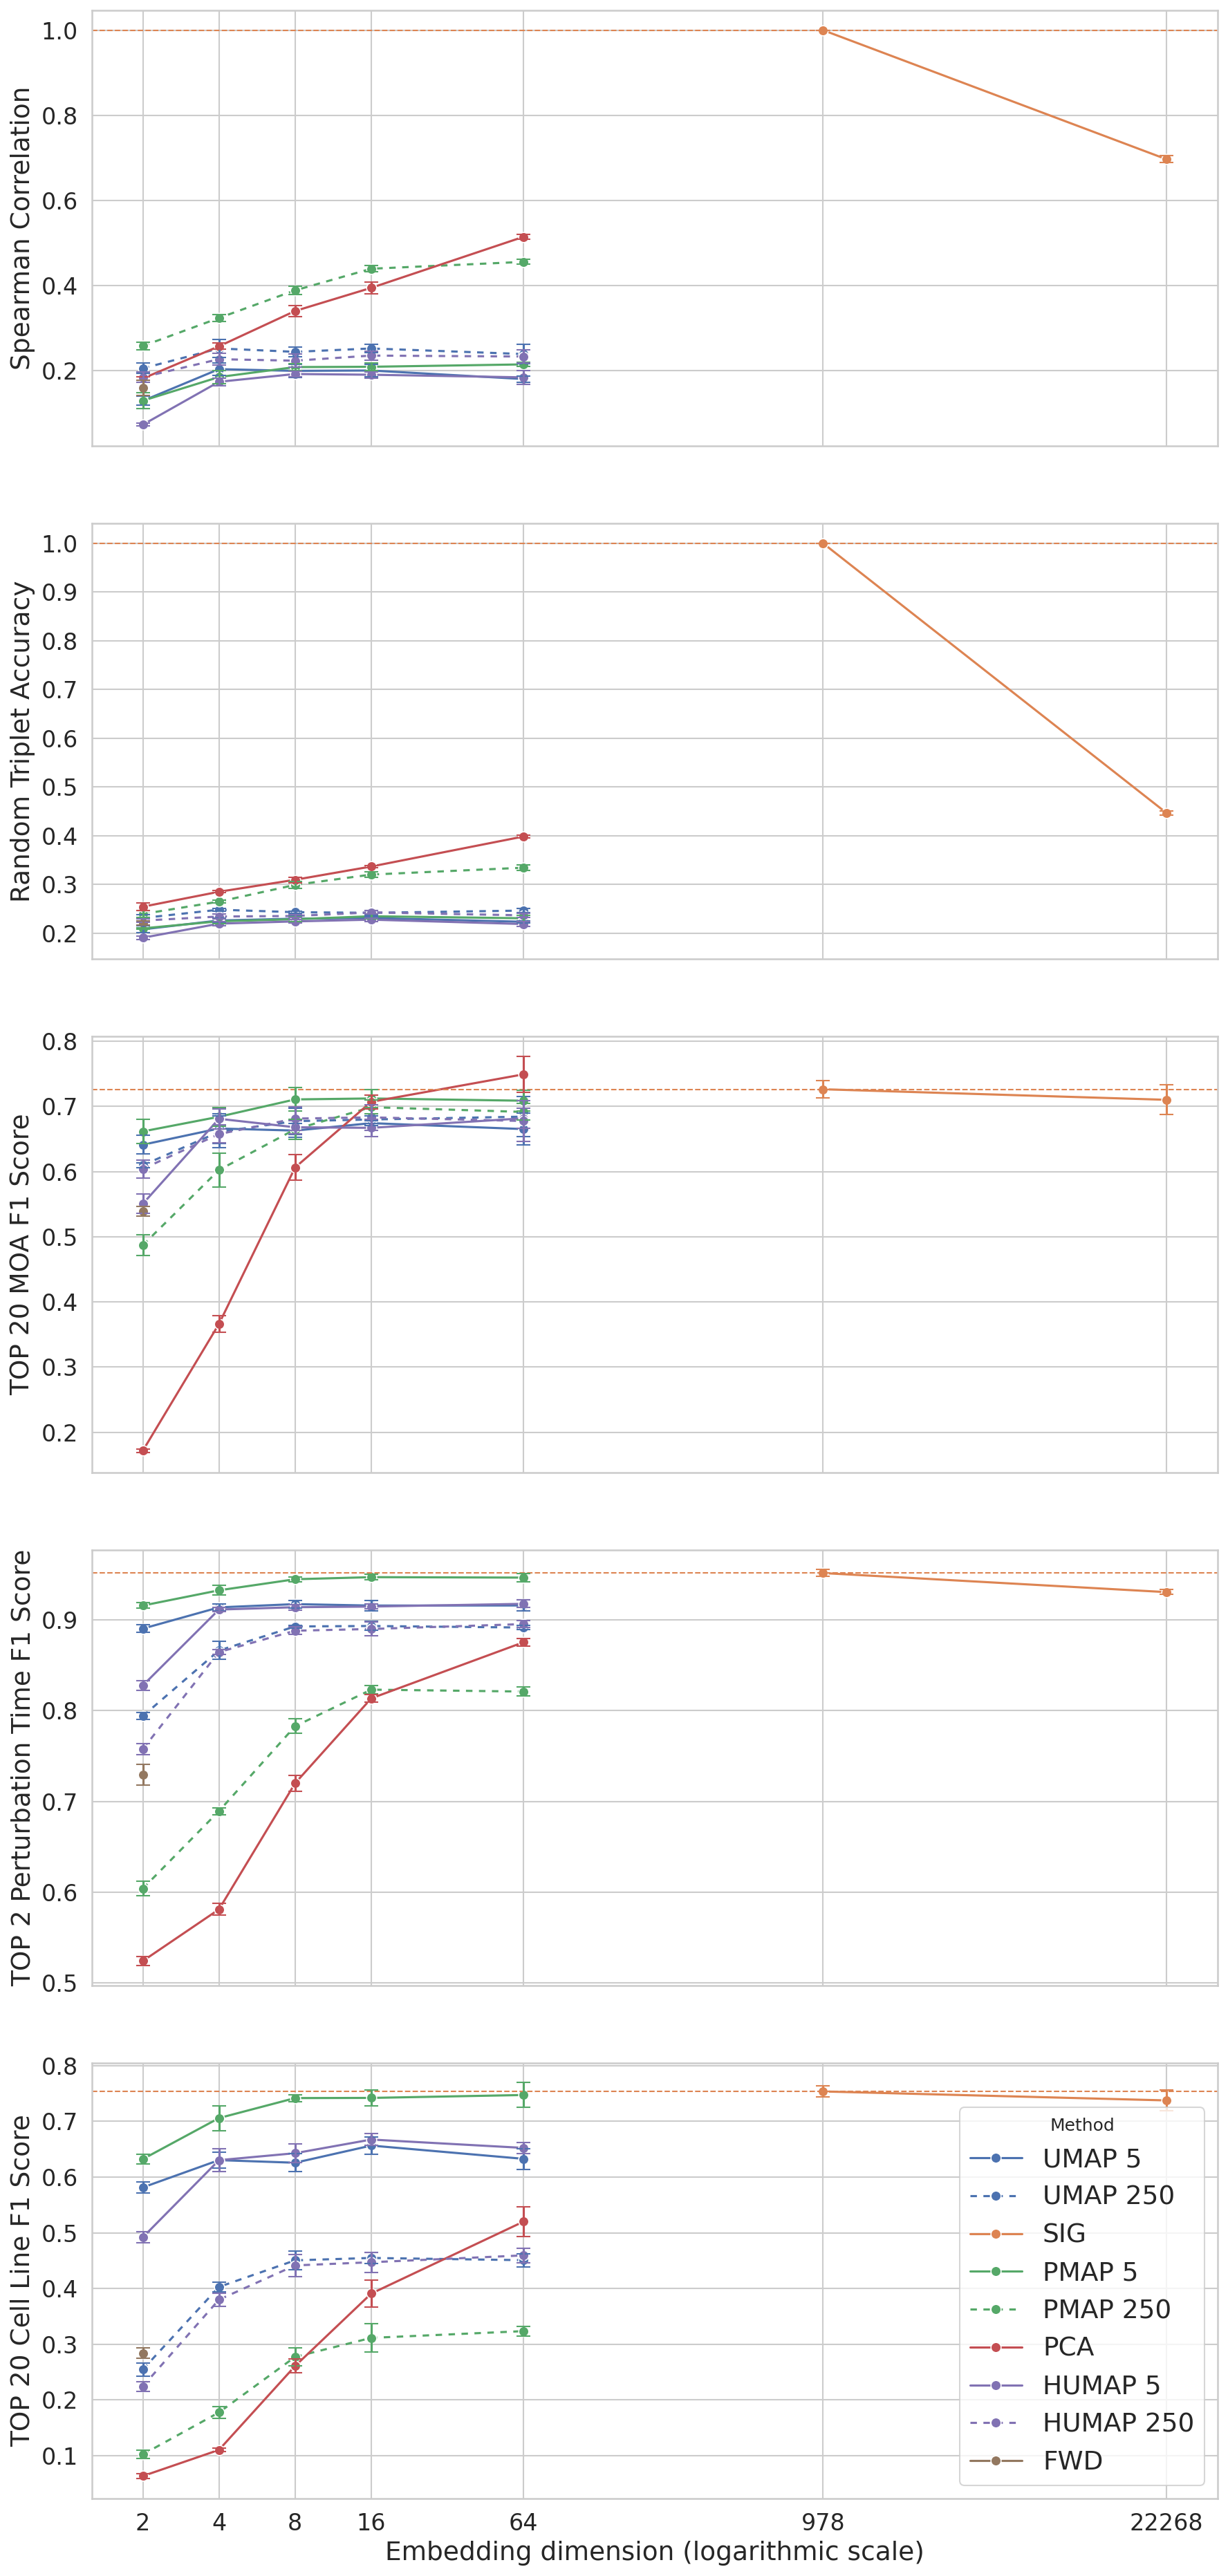

In [4]:
dataset_name = "L1000FWD"
data_subset_name = "landmark"
#dataset_name = "SigComLINCS"
#data_subset_name = "A375"
#data_subset_name = "NPC"
#data_subset_name = "NEU"
#data_subset_name = "HELA"
dimensions = [2, 4, 8, 16, 64]

save_name = dataset_name + "_" + data_subset_name + "_" + '_'.join(str(d) for d in dimensions) + ".png"

metric_df = pd.read_pickle("results/" + dataset_name + "/" + data_subset_name + "_comparison_" + '_'.join(str(d) for d in dimensions) + ".pkl")

df_plot = metric_df.transpose()
df_plot["type"] = np.array([cid[-1] for cid in np.char.split(df_plot.index.values.astype(str), sep ='_')])
df_plot["model"] = np.array(["_".join(cid[:-1]) for cid in np.char.split(df_plot.index.values.astype(str), sep ='_')])
df_plot = df_plot.reset_index().drop('index', axis = 1)
df_plot = df_plot.pivot(index=['model'], columns='type').stack(level=0).stack(level=0).reset_index()
df_plot = df_plot.rename(columns={"level_1": "task", "level_2": "metric"})
df_plot["Latent Dimension"] = np.array([cid[-1] for cid in np.char.split(df_plot.model.values.astype(str), sep ='_')]).astype(int)
df_plot["Method"] = np.array(["_".join(cid[:-1]) for cid in np.char.split(df_plot.model.values.astype(str), sep ='_')])
df_plot = df_plot.sort_values(by=['model'], ascending=False)

plot_dataframes = []
plot_y_labels = []

plot_dataframes.append(df_plot[df_plot.metric == 'Spearman correlation'])
plot_y_labels.append("Spearman Correlation")
plot_dataframes.append(df_plot[df_plot.metric == 'Random triplet accuracy'])
plot_y_labels.append("Random Triplet Accuracy")

df_plot = df_plot[df_plot.metric == 'f1']
#df_plot = df_plot[df_plot.metric == 'roc_auc']
#df_plot = df_plot[df_plot.metric == 'accuracy']

plot_dataframes.append(df_plot[df_plot.task == 'TOP_20_MOA'])
plot_y_labels.append("TOP 20 MOA F1 Score")
plot_dataframes.append(df_plot[df_plot.task == 'TOP_2_Time'])
plot_y_labels.append("TOP 2 Perturbation Time F1 Score")
if dataset_name == "L1000FWD":
    plot_dataframes.append(df_plot[df_plot.task == 'TOP_20_Cell'])
    plot_y_labels.append("TOP 20 Cell Line F1 Score")

x_label = "Embedding dimension (logarithmic scale)"
title = None

line_plot(plot_dataframes, plot_y_labels, x_label, title, save_name)